#  Классификатор, предсказывающий категорию объявления на Авито по его заголовку, описанию и цене.

## Import libraries

In [0]:
# Отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

# Импортируем библиотеки
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import time
from tqdm import tqdm
import os
import gc

import matplotlib.pyplot as plt
%matplotlib inline

## Load datasets

In [3]:
# mount google drive to '/content/drive'
from google.colab import drive
drive.mount('/content/drive')

!cp "drive/My Drive/category.csv" "category.csv"
!cp "drive/My Drive/train.csv" "train.csv"
!cp "drive/My Drive/test.csv" "test.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [35]:
# load train dataset
train_df = pd.read_csv('train.csv')
train_df.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


## Data preprocessing

### Обработаем наши текстовые данные.

Препроцессинг будет состоять из седующих этапов:


1.   Конкатенируем описание к загаловку.
2.   Переведем все символы в нижний регистр.
3.   Токенизируем полученный текст.
4.   Уберем знаки пунктуации, специальные символы, а также стоп-слова.
5.   Если слово (токен) стоит в кавычках, то опустим их.

In [0]:
max_features = 200000
maxlen = 600
embed_size = 300

In [0]:
train_text = train_df['title'] + ' ' + train_df['description']
train_text = train_text.apply(lambda x: x.lower())

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
%%time

tokens = []
for ad in train_text.values.tolist():
    tokens.append(nltk.word_tokenize(ad))

CPU times: user 4min 14s, sys: 1.95 s, total: 4min 16s
Wall time: 4min 16s


In [7]:
%%time 

# let's delete punctuation symbols

punctuation_symbols = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*',
                       '+', '\\', '•',  '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥',
                       '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░',
                       '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■',
                       '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、',
                       '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√',
                       '``', "''", '--', '➜']

tokens = [[i for i in ad if (i not in punctuation_symbols)] for ad in tokens]

CPU times: user 34.3 s, sys: 167 ms, total: 34.4 s
Wall time: 34.4 s


In [8]:
%%time

# cleaning words
tokens = [[i.replace("«", "").replace("»", "") for i in ad] for ad in tokens]

CPU times: user 13.5 s, sys: 52 ms, total: 13.6 s
Wall time: 13.6 s


In [9]:
%%time 

# deleting stop words
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...',''])
tokens = [[i for i in ad if (i not in stop_words)] for ad in tokens]

CPU times: user 34.2 s, sys: 105 ms, total: 34.3 s
Wall time: 34.4 s


### Соберем словарь токен - индекс.

Отсортируем токены по частоте вхождений, выберем первые `nb_words` штук и проиндексируем их.



In [10]:
%%time

ans = set([word for ad in tokens for word in ad])
allWordDist = nltk.FreqDist(word for ad in tokens for word in ad)

nb_words = min(max_features, len(ans))

mostCommon= allWordDist.most_common(nb_words)
voc = {v: k for k, (v,_) in enumerate(mostCommon)}


CPU times: user 26 s, sys: 268 ms, total: 26.3 s
Wall time: 26.3 s


### Преобразуем текст в последовательность индексов.
Сделаем паддинг нулями получившихся массивов, если их длина меньше `maxlen` и возьмем срез длины `maxlen` в противном случае.

In [11]:
%%time

X = []
for ad in tokens:
  buf = [voc.get(word) for word in ad if voc.get(word) is not None][:maxlen]
  X.append(np.pad(buf, (maxlen-len(buf),0), 'constant', constant_values=0))
  
X = np.array(X)

CPU times: user 26.2 s, sys: 25.1 s, total: 51.2 s
Wall time: 51.2 s


In [0]:
Y = train_df['category_id'].values

Z = train_df['price'].values/train_df['price'].values.max()    # scaled prices in [0,1] range

## Embeddings

В качестве эмбеддингов воспользуемся векторами из предобученной на данных *(Russian Wikipedia + Lenta.ru)* модели **`fastText skipgram`**.

Препроцессинг данных состоял из:

```
tokenize(nltk word_tokenize), lowercasing
```



In [36]:
!wget "http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lower_case/ft_native_300_ru_wiki_lenta_lower_case.vec"

--2019-04-25 13:36:05--  http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lower_case/ft_native_300_ru_wiki_lenta_lower_case.vec
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.74
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4140857273 (3.9G) [application/octet-stream]
Saving to: ‘ft_native_300_ru_wiki_lenta_lower_case.vec’

ft_native_300_ru_wi 100%[===================>]   3.86G  3.07MB/s    in 15m 55s 

2019-04-25 13:52:01 (4.14 MB/s) - ‘ft_native_300_ru_wiki_lenta_lower_case.vec’ saved [4140857273/4140857273]



### Соберем матрицу эмбеддингов.

В матрице эмбеддингов на строке с номером, соответствующем индексу токена, стоит его предобученный fastText эмбеддинг.

* Если в предобученном словаре искомый токен отсутствует, то на строке, соответствующей его индексу будет стоять случайный вектор из нормального распределения со средним и стандартным отклонением всех предобученных эмбеддингов.

In [0]:
EMBEDDING_FILE = '/content/ft_native_300_ru_wiki_lenta_lower_case.vec'

def get_coefs(word, *arr):
  return word, np.asarray(arr, dtype='float32')

def load_fasttext(word_index):
  
  with open(EMBEDDING_FILE) as emb_file:
    emb_file.readline() 
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in emb_file)

  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()
  embed_size = all_embs.shape[1]

  nb_words = min(max_features, len(word_index))
  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  for word, i in word_index.items():
      if i >= max_features: continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
  gc.collect()

  return embedding_matrix

In [14]:
%%time

embedding_matrix = load_fasttext(voc)

CPU times: user 2min 5s, sys: 7.55 s, total: 2min 12s
Wall time: 2min 12s


# Model

В качестве модели будем использовать сверточную нейронной сетью.

* Перед полносвязной головой к карте признаков конкатенируем отмаштабированные на [0,1] цены.

In [0]:
batch_size = 512

from argparse import Namespace
args = Namespace()

args.embed_dim=embed_size
args.num_features = max_features
args.class_num = 54
args.kernel_num = 32
args.kernel_sizes = [1, 2, 3, 5, 8]
args.dropout = dropout=0.5
args.hidden_num = 128
args.embedding_init = embedding_matrix
args.batch_size = batch_size

In [0]:
class TextCNN(nn.Module):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional and max-pooling.
    """
    def __init__(self, args):
        super(TextCNN, self).__init__()
        self.args = args

        embedding_dim = args.embed_dim
        embedding_num = args.num_features
        class_number = args.class_num
        in_channel = 1
        out_channel = args.kernel_num
        kernel_sizes = args.kernel_sizes
        hidden_num = args.hidden_num
        
        embedding_init = args.embedding_init

        self.embed = nn.Embedding(embedding_num, embedding_dim)
        if embedding_init is not None:
            self.embed.from_pretrained(torch.from_numpy(embedding_init))#.weight.data.copy_(torch.from_numpy(embedding_init))
        self.conv = nn.ModuleList([nn.Conv2d(in_channel, out_channel, (K, embedding_dim)) for K in kernel_sizes])

        self.dropout = nn.Dropout(args.dropout)
        self.bn = nn.BatchNorm1d(len(kernel_sizes) * out_channel + 1)
        self.fc1 = nn.Linear(len(kernel_sizes) * out_channel + 1, hidden_num)
        self.fc2 = nn.Linear(hidden_num, class_number)


    def forward(self, input_x, input_z):
        """
        :param input_x: a list size having the number of batch_size elements with the same length
        :return: batch_size X num_aspects tensor
        """
        # Embedding
        x = self.embed(input_x)  # dim: (batch_size, max_seq_len, embedding_size)

        # Conv & max pool
        x = x.unsqueeze(1)  # dim: (batch_size, 1, max_seq_len, embedding_size)

        # turns to be a list: [ti : i \in kernel_sizes] where ti: tensor of dim([batch, num_kernels, max_seq_len-i+1])
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv]

        # dim: [(batch_size, num_kernels), ...]*len(kernel_sizes)
        x = [F.avg_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = torch.cat((x, input_z.view(-1,1)), 1)

        # Dropout & batchnorm
        x = self.dropout(x)  # (batch_size,len(kernel_sizes)*num_kernels)
        x = self.bn(x)
        
        # Fully-connected & output
        x = self.fc1(x)  # (batch_size, hidden_num)
        output = self.fc2(x)  # (batch_size, num_aspects)

        return output

In [0]:
def check_accuracy(loader, model):

  num_correct = 0
  num_samples = 0
  running_loss = 0
  y_gt=[]    #gt - ground truth
  y_pred=[]
  model.eval()  # set model to evaluation mode
  model.to(device=device)
  
  with torch.no_grad():
    for x, y, z in loader:
      x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      z = z.to(device=device, dtype=dtype)
      scores = model(x, z)
      _, preds = scores.max(1)
      
      loss = F.cross_entropy(scores, y)
      
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
      running_loss += loss
      y_pred.extend(preds.cpu().numpy())
      y_gt.extend(y.cpu().numpy())
    running_loss /= len(loader)
    acc = accuracy_score(y_pred, y_gt)
    print('Got %d / %d correct (%.2f)    val_loss = %f' % (num_correct, num_samples, 100 * acc, running_loss))
    
    return acc, running_loss

In [0]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    best_model = model
    best_acc = 0
    
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
      tl = 0    # training loss
        
      for t, (x, y, z) in enumerate(train_loader):
          model.train()  # put model to training mode

          x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
          y = y.to(device=device, dtype=torch.long)
          z = z.to(device=device, dtype=dtype)

          scores = model(x, z)
          criterion = nn.CrossEntropyLoss()
          loss = criterion(scores, y)

          # Zero out all of the gradients for the variables which the optimizer
          # will update.
          optimizer.zero_grad()

          # This is the backwards pass: compute the gradient of the loss with
          # respect to each  parameter of the model.
          loss.backward()

          # Actually update the parameters of the model using the gradients
          # computed by the backwards pass.
          optimizer.step()
          
          tl += loss
          
          if t % print_every == 0:
              print('Iteration %d, train_loss = %.4f' % (t, loss.item()))
              acc, _ = check_accuracy(val_loader, model)
              print()

      tl /= len(train_loader)
      acc, vl = check_accuracy(val_loader, model)
      train_loss.append(tl)
      val_loss.append(vl)

      if best_acc < acc:
        best_acc = acc
        best_model = model
          
          
    PATH = "best_model.pth"
          
    torch.save({
            'epoch': epoch,
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)
    
    plt.title('Training Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.plot(train_loss)
    plt.plot(val_loss)

# Datasets and dataloaders

Возьмем 70% от тренировочного датасета на обучение, а 30% на валидацию.

In [0]:
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True)

# split of train sample for train and validation samples
train_X, val_X, train_y, val_y, train_z, val_z = train_test_split(X, Y, Z, test_size=0.3)

train_data = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y), torch.from_numpy(train_z))
val_data = TensorDataset(torch.from_numpy(val_X), torch.from_numpy(val_y), torch.from_numpy(val_z))

train_loader = DataLoader(train_data, **dataloader_args)
val_loader = DataLoader(val_data, **dataloader_args)

In [21]:
del X, Y, Z, train_df, train_text
gc.collect()

25

# Training

In [22]:
USE_GPU = True
cuda = torch.cuda.is_available()
dtype = torch.float32 # we will be using float

if USE_GPU and cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cuda


Iteration 0, train_loss = 4.0025
Got 2937 / 146856 correct (2.00)    val_loss = 3.999878

Iteration 500, train_loss = 1.2983
Got 110196 / 146856 correct (75.04)    val_loss = 1.058744

Got 115093 / 146856 correct (78.37)    val_loss = 0.911127
Iteration 0, train_loss = 1.0258
Got 115127 / 146856 correct (78.39)    val_loss = 0.912977

Iteration 500, train_loss = 0.8666
Got 120420 / 146856 correct (82.00)    val_loss = 0.724636

Got 121806 / 146856 correct (82.94)    val_loss = 0.689494
Iteration 0, train_loss = 0.6282
Got 121794 / 146856 correct (82.93)    val_loss = 0.689402

Iteration 500, train_loss = 0.6691
Got 123478 / 146856 correct (84.08)    val_loss = 0.637454

Got 124116 / 146856 correct (84.52)    val_loss = 0.615119
Iteration 0, train_loss = 0.5775
Got 124115 / 146856 correct (84.51)    val_loss = 0.615532

Iteration 500, train_loss = 0.5626
Got 124646 / 146856 correct (84.88)    val_loss = 0.596358

Got 125139 / 146856 correct (85.21)    val_loss = 0.584975
Iteration 0, tr

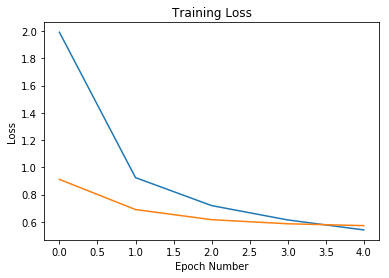

In [34]:
learning_rate = 1e-3

model = None
optimizer = None

model = TextCNN(args)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, epochs=5)

### Разобьем категории по уровням.

Разобьем категории на уровни вложенности и посчитаем accuracy нашей модели на каждом уровне иерархии.


In [24]:
# load dataframe
cat_df = pd.read_csv('category.csv')
# calculate categories depths
depths = [len(i.split('|')) for i in cat_df.name]
# add depth column
cat_df = cat_df.assign(depth=depths)
cat_df.head()

,category_id,name,depth
0,0,Бытовая электроника|Телефоны|iPhone,3
1,1,Бытовая электроника|Ноутбуки,2
2,2,Бытовая электроника|Телефоны|Samsung,3
3,3,Бытовая электроника|Планшеты и электронные кни...,3
4,4,"Бытовая электроника|Игры, приставки и программ...",3


In [25]:
# depths of categories
set(depths)

{2, 3, 4}

In [26]:
# get subcategories at each level
lvl0_cats = []
lvl1_cats = []
lvl2_cats = []
lvl3_cats = []
for name in cat_df.name:
    split = name.split('|')
    lvl0_cats.append(split[0])
    lvl1_cats.append(split[1])
    if len(split) > 2:
        lvl2_cats.append(split[2])
    else:
        lvl2_cats.append(-1)
    if len(split) > 3:
        lvl3_cats.append(split[3])
    else:
        lvl3_cats.append(-1)

# enumerate every label at each level
cat_df = cat_df.assign(lvl0_label=LabelEncoder().fit_transform(lvl0_cats))
cat_df = cat_df.assign(lvl1_label=LabelEncoder().fit_transform(lvl1_cats))
cat_df = cat_df.assign(lvl2_label=LabelEncoder().fit_transform(lvl2_cats))
cat_df = cat_df.assign(lvl3_label=LabelEncoder().fit_transform(lvl3_cats))

cat_df.head()

,category_id,name,depth,lvl0_label,lvl1_label,lvl2_label,lvl3_label
0,0,Бытовая электроника|Телефоны|iPhone,3,0,19,4,0
1,1,Бытовая электроника|Ноутбуки,2,0,11,0,0
2,2,Бытовая электроника|Телефоны|Samsung,3,0,19,2,0
3,3,Бытовая электроника|Планшеты и электронные кни...,3,0,14,28,0
4,4,"Бытовая электроника|Игры, приставки и программ...",3,0,4,19,0


In [0]:
cat_df.drop(['name'], axis=1).to_csv('new_categories.csv', index=False)

## Validation scores

In [36]:
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])

num_correct = 0
num_samples = 0
running_loss = 0
model.eval()  # set model to evaluation mode
model.to(device=device)
y_pred = []
y_test_categories = []

with torch.no_grad():
  for x, y, z in val_loader:
    x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
    y = y.to(device=device, dtype=torch.long)
    z = z.to(device=device, dtype=dtype)
    scores = model(x, z)
    _, preds = scores.max(1)

    loss = F.cross_entropy(scores, y)

    num_correct += (preds == y).sum()
    num_samples += preds.size(0)
    running_loss += loss
    y_pred.extend(preds.cpu().numpy())
    y_test_categories.extend(y.cpu().numpy())
  running_loss /= len(val_loader)
  acc = accuracy_score(y_pred, y_test_categories)
  print(classification_report(y_test_categories, y_pred))
  print('Got %d / %d correct (%.2f)    loss = %f' % (num_correct, num_samples, 100 * acc, running_loss))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2656
           1       0.97      0.93      0.95      2435
           2       0.90      0.89      0.90      3000
           3       0.95      0.93      0.94      2536
           4       0.94      0.93      0.94      2589
           5       0.93      0.95      0.94      2430
           6       0.79      0.83      0.81      2611
           7       0.96      0.96      0.96      2614
           8       0.92      0.93      0.92      2598
           9       0.84      0.91      0.87      2352
          10       0.94      0.91      0.92      2628
          11       0.96      0.94      0.95      2917
          12       0.89      0.93      0.90      2858
          13       0.96      0.96      0.96      2749
          14       0.94      0.95      0.94      2523
          15       0.81      0.81      0.81      2841
          16       0.79      0.86      0.82      2513
          17       0.81    

In [37]:
# load new categories for different levels
cat_df = pd.read_csv('new_categories.csv')
cat_df.head()

# make category_id to lvl{}_label conversion
category_lvl0_label = dict(list(zip(cat_df.category_id, cat_df.lvl0_label)))
category_lvl1_label = dict(list(zip(cat_df.category_id, cat_df.lvl1_label)))
category_lvl2_label = dict(list(zip(cat_df.category_id, cat_df.lvl2_label)))
category_lvl3_label = dict(list(zip(cat_df.category_id, cat_df.lvl3_label)))


for i, d in enumerate([category_lvl0_label, category_lvl1_label, category_lvl2_label, category_lvl3_label]):
    Y_pred = np.vectorize(d.get)(np.array(y_pred))
    Y_test = np.vectorize(d.get)(np.array(y_test_categories))
    acc = accuracy_score(Y_test, Y_pred)
    print('Accuracy for lvl {} categories is {:0.2f}'.format(i, acc))

Accuracy for lvl 0 categories is 0.95
Accuracy for lvl 1 categories is 0.92
Accuracy for lvl 2 categories is 0.87
Accuracy for lvl 3 categories is 0.98


# Test. Unlabled data categorization

In [48]:
# load test dataset
test_df = pd.read_csv('test.csv')
test_df.head()

,item_id,title,description,price
0,489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
1,489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
2,489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
3,489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
4,489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0


### Препроцессинг такой же как и для обучающей выборки.

In [0]:
test_text = test_df['title'] + ' ' + test_df['description']
test_text = test_text.apply(lambda x: x.lower())

# tokenizing text
tokens = []
for ad in test_text.values.tolist():
    tokens.append(nltk.word_tokenize(ad))

# deleting punctuation symbols
tokens = [[i for i in ad if (i not in punctuation_symbols)] for ad in tokens]

# cleaning words
tokens = [[i.replace("«", "").replace("»", "") for i in ad] for ad in tokens]

# deleting stop words
tokens = [[i for i in ad if (i not in stop_words)] for ad in tokens]

# text to sequence and padding
X = []
for ad in tokens:
  buf = [voc.get(word) for word in ad if voc.get(word) is not None][:maxlen]
  X.append(np.pad(buf, (maxlen-len(buf),0), 'constant', constant_values=0))
  
X = np.array(X)
Z = test_df['price'].values/test_df['price'].values.max()    # scaled prices in [0,1] range

### Test dataset and dataloader

In [41]:
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=8, pin_memory=True)

test_data = TensorDataset(torch.from_numpy(X), torch.from_numpy(Z))

test_loader = DataLoader(test_data, **dataloader_args)

del X, Z, tokens, test_text
gc.collect()

0

# Categories for `test.csv`

In [0]:
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()  # set model to evaluation mode
model.to(device=device)
y_pred = []

with torch.no_grad():
  for x, z in test_loader:
    x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
    z = z.to(device=device, dtype=dtype)
    scores = model(x, z)
    _, preds = scores.max(1)

    y_pred.extend(preds.cpu().numpy())
    
test_df = test_df.assign(category_id=y_pred)
test_df[['item_id', 'category_id']].to_csv('submission.csv', index=False)